In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd -q ..

C:\Users\remil\.conda\envs\lcpfn\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import lcpfn 
import torch
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

import torch
from torch.utils.data import TensorDataset, DataLoader


In [ ]:
# curve data is 100 points
# split data into 50 and 50
# given first 50 points predict next 50 points
input_length = 15  # Num input elements
target_length = 85  # Num target elements

# get data (100 curves)
# Y seems to be the true curve data, X is just indecies???
get_batch_func = lcpfn.create_get_batch_func(prior=lcpfn.sample_from_prior)
X, Y, Y_noisy = get_batch_func(batch_size=100, seq_len=100, num_features=1)

# Splitting data into input and target
# input given to transformer who's output is compared to target
inputs = Y[:, :input_length]
targets = Y[:, input_length:]

#load data
dataset = TensorDataset(inputs, targets)
data_loader = DataLoader(
    dataset, batch_size=10, shuffle=True
)

# not already implemented by torch
# encodes positional data of order the tokens are in the sequence
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return x


class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dim_feedforward):
        super(TransformerModel, self).__init__()
        self.model_dim = model_dim
        self.pos_encoder = PositionalEncoding(model_dim)
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=num_heads, dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layers, num_layers=num_layers
        )
        self.encoder = nn.Linear(input_dim, model_dim)
        self.decoder = nn.Linear(model_dim, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.encoder(src) * math.sqrt(self.model_dim)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        # Use the representation of the last position
        output = output[:, -1, :]
        output = self.decoder(output)
        output = torch.sigmoid(output)
        return output.squeeze(-1)  # Optionally remove the last dimension for a cleaner output shape



model = TransformerModel(
    input_dim=1,
    model_dim=512,
    num_heads=8,
    num_layers=6,
    dim_feedforward=2048,
)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1):
    model.train()
    total_loss = 0
    for input_sequence, target_sequence in data_loader:
        optimizer.zero_grad()

        # Reshape for model's expected input
        input_sequence = input_sequence.unsqueeze(-1)  # Shape: [batch_size, seq_len, features]

        # Initialize the tensor for model predictions
        predictions = torch.zeros(input_sequence.shape[0], target_length, 1)  # Shape: [batch_size, target_length, features]

        # Autoregressive generation inside the training loop
        for i in range(target_length):
            # Generate prediction for the next time step
            # print("input_shape:", input_sequence.shape)
            output = model(input_sequence)  # Assume the model is designed to output the next step
            # print("output shape:",output.shape)
            predictions = output

            # Prepare input for the next step
            next_input = target_sequence[:, i].unsqueeze(-1).unsqueeze(-1)  # Using true value (teacher forcing)
            input_sequence = torch.cat((input_sequence, next_input), dim=1)

        loss = criterion(predictions, target_sequence.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch}, Loss: {total_loss / len(data_loader)}")

input_shape: torch.Size([10, 15, 1])
output shape: torch.Size([10])
input_shape: torch.Size([10, 16, 1])
output shape: torch.Size([10])
input_shape: torch.Size([10, 17, 1])
output shape: torch.Size([10])
input_shape: torch.Size([10, 18, 1])
output shape: torch.Size([10])
input_shape: torch.Size([10, 19, 1])
output shape: torch.Size([10])
input_shape: torch.Size([10, 20, 1])
output shape: torch.Size([10])
input_shape: torch.Size([10, 21, 1])
output shape: torch.Size([10])
input_shape: torch.Size([10, 22, 1])
output shape: torch.Size([10])
input_shape: torch.Size([10, 23, 1])
output shape: torch.Size([10])
input_shape: torch.Size([10, 24, 1])
output shape: torch.Size([10])
input_shape: torch.Size([10, 25, 1])
output shape: torch.Size([10])
input_shape: torch.Size([10, 26, 1])
output shape: torch.Size([10])
input_shape: torch.Size([10, 27, 1])
output shape: torch.Size([10])
input_shape: torch.Size([10, 28, 1])
output shape: torch.Size([10])
input_shape: torch.Size([10, 29, 1])
output shap

## Load trained LC-PFN model

In [21]:
model = lcpfn.LCPFN()

## Generate a learning curve from the prior

In [22]:
print("test")

test


(0.0, 1.0)

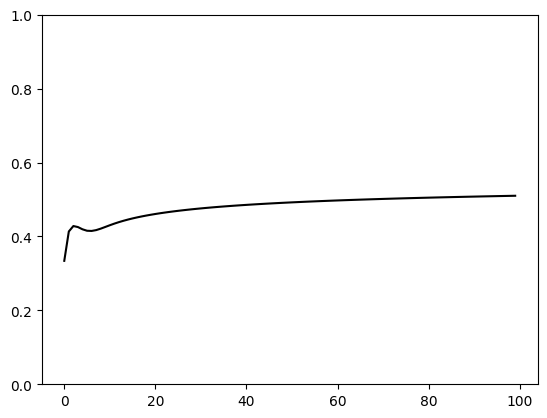

In [13]:
prior = lcpfn.sample_from_prior(np.random)
curve, _ = prior()
plt.plot(curve, "black")
plt.ylim(0, 1)

## Extrapolate the learning curve with a cutoff of 10%

In [14]:
# construct 

x = torch.arange(1, 101).unsqueeze(1)
y = torch.from_numpy(curve).float().unsqueeze(1)
cutoff = 10

In [46]:
def predict_single_sequence(model, input_sequence):
    model.eval()  # Ensure the model is in eval mode
    with torch.no_grad():  # No gradients needed
        # Assuming input_sequence is already a PyTorch tensor with the right shape and dtype
        print(input_data.shape)
        prediction = model(torch.tensor(input_data))
        # Convert the prediction back to a Python number for easy interpretation
        print(prediction.shape)
        predicted_value = prediction.item()
    return predicted_value

# Example usage
input_data = y[:15].unsqueeze(0)  # Example input sequence
input_tensor = torch.tensor(input_data, dtype=torch.float).unsqueeze(0).unsqueeze(-1)
predictions = predict_single_sequence(model, input_tensor)
print(f"Predicted Value: {predictions}")

torch.Size([1, 15, 1])
torch.Size([1])
Predicted Value: -0.2924157977104187


C:\Users\remil\AppData\Local\Temp\ipykernel_8680\2766388783.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_data, dtype=torch.float).unsqueeze(0).unsqueeze(-1)
C:\Users\remil\AppData\Local\Temp\ipykernel_8680\2766388783.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prediction = model(torch.tensor(input_data))


In [15]:
predictions = model.predict_quantiles(x_train=x[:cutoff], y_train=y[:cutoff], x_test=x[cutoff:], qs=[0.05, 0.5, 0.95])

AttributeError: 'TransformerModel' object has no attribute 'predict_quantiles'

IndexError: too many indices for tensor of dimension 1

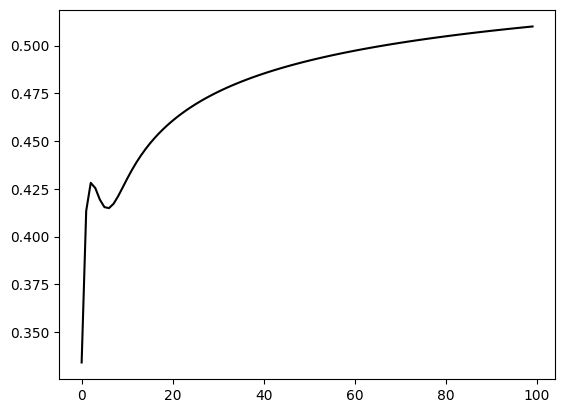

In [19]:
# plot data
plt.plot(curve, "black", label="target")

# plot extrapolation
plt.plot(x[cutoff:], predictions[:, 1], "blue", label="Extrapolation by PFN")
plt.fill_between(
        x[cutoff:].flatten(), predictions[:, 0], predictions[:, 2], color="blue", alpha=0.2, label="CI of 90%"
)

# plot cutoff
plt.vlines(cutoff, 0, 1, linewidth=0.5, color="k", label="cutoff")
plt.ylim(0, 1)
plt.legend(loc="lower right")